## PREDICT THE BURNED AREA OF FOREST FIRES WITH NEURAL NETWORKS

## Import libraries

In [1]:
#load the libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False)
import warnings
warnings.filterwarnings('ignore')
! pip install tensorflow[and-cuda]
# Verify the installation:
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

#pip install keras
#https://www.tensorflow.org/install/pip#windows

[]


In [2]:
# Generating reproducible results from same code
tf.random.set_seed(14)

In [4]:

forest=pd.read_csv("/content/forestfires.csv")
forest.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [5]:
df = forest.copy() #Removing the dummies at this time
df.drop(df.columns[11:30],axis=1,inplace = True)

In [6]:
df.shape

(517, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [8]:
df.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'size_category'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [10]:
df.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

# Feature Analysis

In [11]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [12]:
 # The dataset is biased. Lets remove the bias.
df.size_category.value_counts()

small    378
large    139
Name: size_category, dtype: int64

# label encoding

In [13]:
#We are going to perform label encoding since it is faster than dummy variables

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month)
df.day= label_encoder.fit_transform(df.day)
df.size_category= label_encoder.fit_transform(df.size_category)
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


# Removing Bias in the Dataset

In [14]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()
#SMOTEK TECHNIQUE

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 371, 0: 371})


# Train | Split dataset

In [15]:
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

# Neural Network Modelling

Building the Model

In [16]:
# Create your first MLP in Keras
import keras
from keras.models import Sequential
from keras.layers import Dense

In [17]:
# create model
model = Sequential()
model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
hist = model.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=10)

Epoch 1/50
35/35 [==============================] - 2s 11ms/step - loss: 0.6941 - accuracy: 0.5043 - val_loss: 0.6929 - val_accuracy: 0.5058
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.6883 - accuracy: 0.6138 - val_loss: 0.6816 - val_accuracy: 0.5698
Epoch 3/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6718 - accuracy: 0.6225 - val_loss: 0.6448 - val_accuracy: 0.6802
Epoch 4/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6310 - accuracy: 0.7061 - val_loss: 0.5598 - val_accuracy: 0.8198
Epoch 5/50
35/35 [==============================] - 0s 5ms/step - loss: 0.5215 - accuracy: 0.8184 - val_loss: 0.4920 - val_accuracy: 0.7500
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.4205 - accuracy: 0.8703 - val_loss: 0.3437 - val_accuracy: 0.9360
Epoch 7/50
35/35 [==============================] - 0s 3ms/step - loss: 0.3214 - accuracy: 0.9251 - val_loss: 0.2833 - val_accuracy: 0.8837
Epoch 8/50
35/35 [=

# Model Evaluation

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.0632 - accuracy: 0.9641


In [19]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [20]:
hist_df = pd.DataFrame(hist.history)
hist_df["epoch"]=hist.epoch
hist_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.028648,0.988473,0.060763,0.976744,45
46,0.047940,0.982709,0.052853,0.976744,46
47,0.019013,0.997118,0.048379,0.982558,47
48,0.027648,0.985591,0.081177,0.965116,48
49,0.048988,0.979827,0.074711,0.970930,49


# Visualize Training History

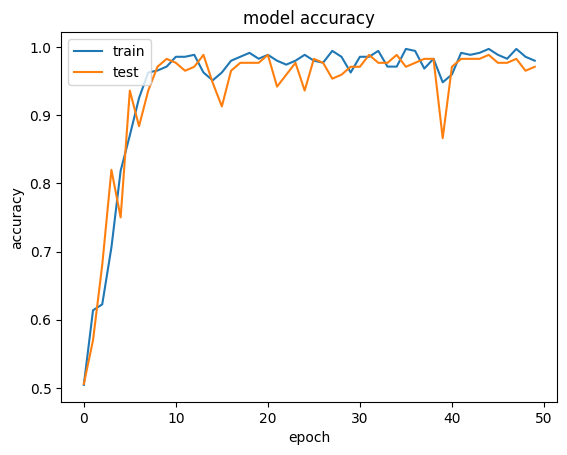

In [21]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

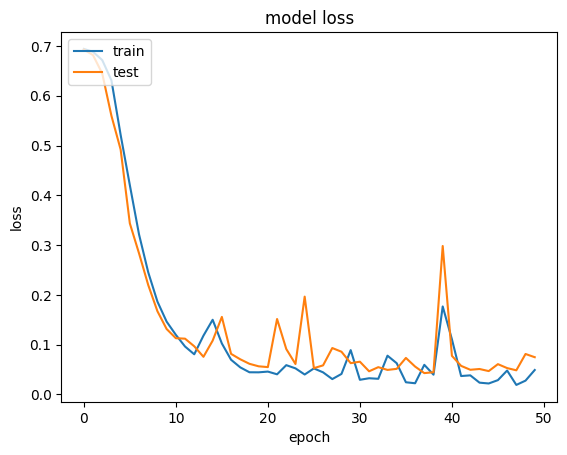

In [22]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')